<a href="https://colab.research.google.com/github/david900125/113NCHU_Big-Data-Analytics-for-Finance/blob/main/week11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-39-fedfaf8176a4>:131: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  stock['Date'] = pd.to_datetime(stock['Date'])
<ipython-input-39-fedfaf8176a4>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.targets = torch.tensor(targets, dtype=torch.float32)
<ipython-input-39-fedfaf8176a4>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = self.texts[idx]


Epoch 1/100, Loss: 95448416.0000
Epoch 2/100, Loss: 97890552.0000
Epoch 3/100, Loss: 91679430.0000
Epoch 4/100, Loss: 97815318.0000
Epoch 5/100, Loss: 96691890.0000
Epoch 6/100, Loss: 91863130.0000
Epoch 7/100, Loss: 92849798.0000
Epoch 8/100, Loss: 89465850.0000
Epoch 9/100, Loss: 92093058.0000
Epoch 10/100, Loss: 96080154.0000
Epoch 11/100, Loss: 94491674.0000
Epoch 12/100, Loss: 94432464.0000
Epoch 13/100, Loss: 90658806.0000
Epoch 14/100, Loss: 98053370.0000
Epoch 15/100, Loss: 96860308.0000
Epoch 16/100, Loss: 93404052.0000
Epoch 17/100, Loss: 92578832.0000
Epoch 18/100, Loss: 89804162.0000
Epoch 19/100, Loss: 94409074.0000
Epoch 20/100, Loss: 94537814.0000
Epoch 21/100, Loss: 93355380.0000
Epoch 22/100, Loss: 95441856.0000
Epoch 23/100, Loss: 85289716.0000
Epoch 24/100, Loss: 86613180.0000
Epoch 25/100, Loss: 86489512.0000
Epoch 26/100, Loss: 78032320.0000
Epoch 27/100, Loss: 81006396.0000
Epoch 28/100, Loss: 78939350.0000
Epoch 29/100, Loss: 76860248.0000
Epoch 30/100, Loss: 687

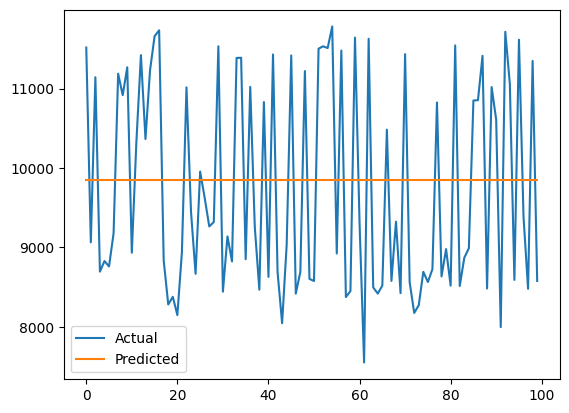

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
import numpy as np
import pandas as pd

# ====== 模擬數據 ======
class StockDataset(Dataset):
    def __init__(self, texts, price_sequences, targets):
        """
        texts: (N,) 的文本列表
        price_sequences: (N, T, F) 的股價時間序列張量
        targets: (N,) 的目標變動幅度
        """
        self.texts = texts
        self.price_sequences = torch.tensor(price_sequences, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        text = self.texts[idx]
        price_sequence = self.price_sequences[idx]
        target = self.targets[idx]

        # 使用 BERT Tokenizer 處理文本
        tokens = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors="pt",
        )
        return {
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0),
            "price_sequence": price_sequence,
            "target": target,
        }

# ====== BERT 模型 ======
class BertSemanticModel(nn.Module):
    def __init__(self, output_dim=128):
        super(BertSemanticModel, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(self.bert.config.hidden_size, output_dim)

    def forward(self, input_ids, attention_mask):
        # 使用 BERT 提取語意特徵
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]  # [CLS] token 特徵
        return self.fc(cls_token)

# ====== LSTM 模型 ======
class LSTMModel(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=128, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        hn = hn[-1, :, :]  # (batch_size, hidden_dim)
        return self.fc(hn)

# ====== 多模態融合模型 ======
class MultiModalModel(nn.Module):
    def __init__(self, bert_output_dim=128, lstm_output_dim=128, final_output_dim=1):
        super(MultiModalModel, self).__init__()
        self.bert = BertSemanticModel(output_dim=bert_output_dim)
        self.lstm = LSTMModel(output_dim=lstm_output_dim)
        self.fc = nn.Sequential(
            nn.Linear(bert_output_dim + lstm_output_dim, 64),
            nn.ReLU(),
            nn.Linear(64, final_output_dim)
        )

    def forward(self, input_ids, attention_mask, price_sequences):
        bert_features = self.bert(input_ids, attention_mask)  # 提取文章語意特徵
        lstm_features = self.lstm(price_sequences)  # 提取股價序列特徵
        combined_features = torch.cat((bert_features, lstm_features), dim=1)  # 晚期融合
        output = self.fc(combined_features)  # 回歸預測
        return output

# ====== 訓練與評估 ======
def train_model(model, dataloader, criterion, optimizer, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            price_sequences = batch["price_sequence"].to(device)
            targets = batch["target"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, price_sequences).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")

def evaluate_model(model, dataloader):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            price_sequences = batch["price_sequence"].to(device)
            targets = batch["target"]

            outputs = model(input_ids, attention_mask, price_sequences).squeeze()
            preds.extend(outputs.cpu().numpy())
            actuals.extend(targets.numpy())
    preds = np.array(preds)
    actuals = np.array(actuals)
    mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
    print(f"MAPE: {mape:.2f}%")
    return preds, actuals

# ====== 主程式 ======
if __name__ == "__main__":

    stock = pd.read_csv(r'/content/DJIA_table(train).csv')
    stock['Date'] = pd.to_datetime(stock['Date'])
    stock = stock.set_index('Date')
    context = pd.read_csv(r'/content/Combined_News_DJIA(train).csv.zip')
    context['Date'] = pd.to_datetime(context['Date'])
    context = context.set_index('Date')
    df = pd.concat([stock, context], axis=1)

    texts = df['Top1'].head(100)
    window_size = 10
    price_sequences = [
      df[['Open','High','Low','Close','Volume']].iloc[i:i + window_size].values
      for i in range(0, len(df), window_size)
    ][:100]
    targets = df['Close'].head(100)

    dataset = StockDataset(texts, price_sequences, targets)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # 設置設備
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 初始化模型、損失函數和優化器
    model = MultiModalModel().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 訓練
    train_model(model, dataloader, criterion, optimizer, num_epochs=100)

    # 評估
    preds, actuals = evaluate_model(model, dataloader)

    # 可視化結果
    import matplotlib.pyplot as plt
    plt.plot(actuals, label="Actual")
    plt.plot(preds, label="Predicted")
    plt.legend()
    plt.show()
